<a href="https://colab.research.google.com/github/mardhiahnajwa/assignments-dliva/blob/main/Assignment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 2
On the fruit dataset, you are required to prepare one notebook that can run on google collab containing:

1) The training of the model on the dataset after modification to improve the performance of the model.(10M)

2) The training of the model on the dataset after data-centric strategies.(10M)

3) Save the final model and load again on the notebook. Perform inference on two new samples (fruit data captured from your phone). (2Marks)
** the model can be any model, custom or your own defined model




*   **Load dataset**








In [204]:
#mount drive to place data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [205]:
# uncomment to download fruit dataset
#!gdown https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip 

In [206]:
#!unzip  fruit_dataset_exercise.zip -d /content/gdrive/MyDrive/fruit_dataset

In [207]:
#!rm -rf /content/fruit_dataset_exercise.zip

#Question 1



*   **Import module and load model**



In [208]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torchsummary import summary

In [209]:
#chosen pretrained model is googlenet
googlenet = models.googlenet(pretrained=True)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [210]:
#normal image transformation for fruit dataset
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [211]:
# Load the Data

# Set train and valid directory paths

from google.colab import drive
drive.mount('/content/gdrive')

dataset = '/content/gdrive/My Drive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size changed to lower
batchSize = 16

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
4


In [212]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [213]:
input_size = (3,32,32)



*   **Modification of model**


In [214]:
#modification of model is here

num_features = googlenet.fc.in_features
googlenet.dropout = nn.Dropout(p=0.25)
googlenet.fc = nn.Linear(num_features, 4)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
googlenet.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track



*   Model is being saved after training



In [215]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'fruit_googlenet'+str(epoch)+'.pt')
            
    return model, history

In [216]:
#Train model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(googlenet, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.0604, Accuracy: 54.1267%, 
		Validation : Loss : 1.6607, Accuracy: 30.9598%, Time: 6.0511s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6835, Accuracy: 76.9674%, 
		Validation : Loss : 1.3201, Accuracy: 58.8235%, Time: 6.8960s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.5513, Accuracy: 83.3013%, 
		Validation : Loss : 1.1364, Accuracy: 71.8266%, Time: 5.9505s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.4635, Accuracy: 86.7562%, 
		Validation : Loss : 0.9939, Accuracy: 79.5666%, Time: 5.9868s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.4056, Accuracy: 88.4837%, 
		Validation : Loss : 0.9220, Accuracy: 81.4241%, Time: 5.8794s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.3594, Accuracy: 88.8676%, 
		Validation : Loss : 0.8896, Accuracy: 80.8050%, Time: 5.7971s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.3360, Accuracy: 89.4434%, 
		Validation : Loss : 0.8419, Accuracy: 80.8050%, Time: 5.9028s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2991, Accuracy: 91.

#Question 2



*   Using the same data, just transform it using albumenations.
*   The transformation is done at the data only





In [218]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAutocontrast(),
        transforms.CenterCrop(size=224),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}



*  Run again the trained model



In [219]:
dataset = '/content/gdrive/My Drive/fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size changed to lower
batchSize = 16

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=transforms['test'])
}

4


In [220]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [221]:
input_size = (3,32,32)



*   Model saved alongside set timing


In [222]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'fruitdata_googlenet'+str(epoch)+'.pt')
            
    return model, history

In [223]:
#Train model for 10 epochs
 
num_epochs = 10
trained_model2, history = train_and_validate(googlenet, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.3288, Accuracy: 90.0192%, 
		Validation : Loss : 0.7468, Accuracy: 80.4954%, Time: 6.2427s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3244, Accuracy: 88.6756%, 
		Validation : Loss : 0.7407, Accuracy: 79.8762%, Time: 6.2807s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2987, Accuracy: 89.6353%, 
		Validation : Loss : 0.6999, Accuracy: 81.1146%, Time: 6.1209s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2755, Accuracy: 90.7869%, 
		Validation : Loss : 0.7078, Accuracy: 80.8050%, Time: 6.2629s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2719, Accuracy: 89.4434%, 
		Validation : Loss : 0.6541, Accuracy: 82.3529%, Time: 6.8280s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2713, Accuracy: 90.5950%, 
		Validation : Loss : 0.6783, Accuracy: 81.4241%, Time: 6.4180s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2475, Accuracy: 91.3628%, 
		Validation : Loss : 0.6268, Accuracy: 83.2817%, Time: 6.3654s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2510, Accuracy: 89.

#Question 3



*   Model saved for model modified was saved inside fruit_googlenet0-9.pt
*   Model saved for data modified was saved inside fruitdata_googlenet0-9.pt





---



*   Load the saved model
*   Load 2 image
*   Run prediction on data image





In [224]:
from torchvision import transforms
import io

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

categories = os.listdir(train_directory)

In [225]:
model = torch.load('/content/fruitdata_googlenet9.pt') #('/content/fruit_googlenet9.pt') for the model centric cnn
model.eval()

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor=tensor.to(device)
    output = model.forward(tensor)
    
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), categories[classes.item()]


watermelon  at confidence score:0.99


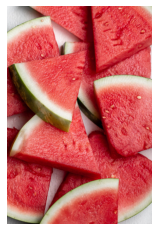

In [226]:
image_path="/content/gdrive/MyDrive/fruit/wt2.jpeg" #just change the path using the fruit folder containing dataset or can use own data
image = plt.imread(image_path)
plt.imshow(image)
plt.axis('off')

with open(image_path, 'rb') as f:
    image_bytes = f.read()

    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

#Notes



*   The reason that durian is not confidently predicted is because the train dataset is only 2, which is not enough to learn about the durian's features in a picture.
*   The other data is classified with high confidence and almost accurately.
*   Both model give high accuracy on all the predictions with slightly higher for the data-centric model. This might be due to the reason that data centric focuses on the features that could help the model learn better.


